In [1]:
import os, glob
import cv2
import matplotlib.pyplot as plt
import torch

from ultralytics import YOLO
import easyocr
import utils

<h3 style="color:orange">Hyperparameters</h3>

In [3]:
DEVICE="cuda" if torch.cuda.is_available() else "cpu"

vid_dir=["./dataset/video/demo.mp4"]

vid=cv2.VideoCapture(vid_dir[0])

# video metadata
frame_count=int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
W=int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
H=int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS=int(vid.get(cv2.CAP_PROP_FPS))

print(f"frame count: {frame_count}\nframe width: {W}\nframe hight: {H}\nFPS: {FPS}")

frame count: 631
frame width: 1114
frame hight: 720
FPS: 30


<h3 style="color:orange">Load Model</h3>

In [ ]:
model_weight=[path for path in glob.glob("./Model/weights/*.pt")]
print(model.weight)
model=YOLO(model_weight[1]).to(DEVICE)

matter_tracker=utils.sort.Sort()   #use for tracting object in continues frames

print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

<h3 style="color:orange">model infernce</h3>

In [4]:
pred=model(img)[0]
# print(pred)
# print(type(pred), len(pred), type(pred[0]))

detection=[]

for x1,y1,x2,y2,score,classes in pred.boxes.data.tolist():
    if score>0.65:
        print(f"{score=}")
        detection.append([int(x1),int(y1),int(x2),int(y2),score])


0: 448x640 1 License_Plate, 475.5ms
Speed: 44.6ms preprocess, 475.5ms inference, 534.7ms postprocess per image at shape (1, 3, 448, 640)
score=0.7315002679824829


<h3 style="color:orange">bounding box exraction</h3>

(-0.5, 159.5, 72.5, -0.5)

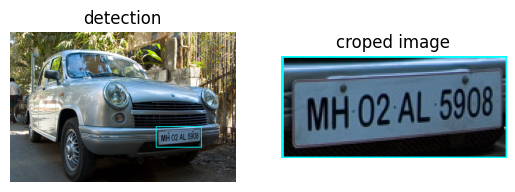

In [5]:
# boundin box extracton
extract_data=[]

for x1,y1,x2,y2,score in detection:
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,255),2)
    crop_img=img[y1:y2,x1:x2]
    x=cv2.cvtColor(crop_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite("./temp/extract_img.png",x)
    

plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.title("detection")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(crop_img,cmap="gray")
plt.title("croped image")
plt.axis("off")

<h3 style="color:orange">OCR extraction</h3>

In [6]:
reader=easyocr.Reader(['en'],gpu=True if DEVICE=="cuda" else False)

detect=reader.readtext(crop_img)
# print(detect)
for bbox,text,score in detect:
    print(f"{text=}, {score=}")

text='MH 02 AL 5908', score=0.9909633011861284
